## Code required to create Figure 4
Entire notebook takes ~35 minutes to run on Intel i7-10750 using > 10GB RAM

Note: figure 4 is towards the end of the notebook

In [1]:
import collections
import datetime
import glob
import re
import os
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms

sns.set_context('paper')

# Functions to load CMIP6 runs

In [2]:
def make_combined_df_from_data_paths(data_paths, ignored_data_paths, date_format="\d{2}:\d{2}:\d{2}", data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2] + "_" + os.path.split(data_paths[first_ind])[-1].split("_")[4]
        wrote_data_name = True
    df.columns = ["time", data_name]
    # remove time from date
    df['time'] = df['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            # print(f)
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2] + "_" + os.path.split(f)[-1].split("_")[4]
        else:
            current_data_name = data_name
        current.columns = ["time", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
        df = df.merge(current, how='outer', on='time')
    df = df.set_index('time')
    df = df.sort_index()
    return df


def make_combined_df_from_data_paths_for_bracegirdle(data_paths, ignored_data_paths, data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2] + "_" + os.path.split(data_paths[first_ind])[-1].split("_")[4]
        wrote_data_name = True
    df.columns = ["year", data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
    # remove time from date
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2] + "_" + os.path.split(f)[-1].split("_")[4]
        else:
            current_data_name = data_name
        current.columns = ["year", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        df = df.merge(current, how='outer', on='year')
    df = df.set_index('year')
    df = df.sort_index()
    return df


def remove_unwanted_columns(data):
    for col in data.columns:
        if col in COLS_TO_REMOVE:
            data = data.drop(col, axis=1)
    return data

# Globals

In [3]:
METRIC_NAMES = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Simpson 2017",\
                        "Grise & Polvani 2017", "Bracegirdle et al. 2018", "Zappa et al. 2018", "Kerr et al. 2020"]
METRIC_DATA_NAMES = ['Woollings2010_NorthPacific', 'BarnesPolvani2013_NorthPacific',\
                     'BarnesSimpson2017_NorthPacific','GrisePolvani2017_NorthPacific', 'Bracegirdle2018_NorthPacific',\
                     'Zappa2018_NorthPacific', 'Kerr2020_NorthPacific'] # , "Barnes & Polvani 2015"
METRIC_SHORTHAND = ["W10", "BP13", "BS17", "GP17", "B18", "Z18", "K20"] # "BP15",

In [4]:
METRIC_LABEL_RENAMER = dict(zip(METRIC_DATA_NAMES, METRIC_NAMES))
METRIC_SHORTHAND_LABEL_RENAMER = dict(zip(METRIC_NAMES, METRIC_SHORTHAND))

In [5]:
ALL_MONTHS = ["January", "February", "March", "April", "May", "June",\
              "July", "August", "September", "October", "November", "December"]
ALL_MONTHS_SHORT = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [6]:
MONTH_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS))
MONTH_SHORT_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS_SHORT))

# Load CMIP6 SSP5-8.5 

In [7]:
PROJ_START_DATE = "2070-01-01"
PROJ_END_DATE = "2099-12-31"
PERIOD_NUMBER_OF_DAYS = (pd.to_datetime(PROJ_END_DATE) - pd.to_datetime(PROJ_START_DATE)).days
MISSING_NUM_DAYS_THRESHOLD = 0.05 ## only allow for up to 5% less duration in data 

In [8]:
CMIP6_2070to2100_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_AllScenarioMIP_daily_runs/outputs/ua_day*ssp585*"

In [9]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Zappa et al. 2018", "Kerr et al. 2020"] # , "Barnes & Polvani 2015"

COLS_TO_REMOVE = ["10_day_average", "plev"]

In [10]:
print("Num of North Pacific files:", len(glob.glob(CMIP6_2070to2100_dir + "North Pacific" + "*")))

Num of North Pacific files: 870


In [11]:
%%time
## takes 8 seconds on Intel i7-10750 
time_ranges = []
failed_data_paths = []
data_paths_not_enough_days = []

date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_2070to2100_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except KeyError as e:
        ## we expect bracegirlde to fail this time formatting (as it is an annual metric) 
        assert str(e) == "'time'", f"failed for another reason: {e}"
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    current_data_period_in_days = (pd.to_datetime(last_time) - pd.to_datetime(first_time)).days
    ## check there is enough days
    if (PERIOD_NUMBER_OF_DAYS * MISSING_NUM_DAYS_THRESHOLD) < current_data_period_in_days:
        time_ranges.append(str(first_time)+'to'+str(last_time))
    else:
        data_paths_not_enough_days.append(file_path)

CPU times: user 39.5 s, sys: 1.34 s, total: 40.8 s
Wall time: 41.1 s


#### check dates look ok

In [12]:
collections.Counter(time_ranges)

Counter({'2015-01-01to2100-12-31': 559,
         '2015-01-01to2100-12-30': 112,
         '2015-01-01to2100-12-22': 32,
         '2015-01-01to2100-12-21': 16,
         '2015-01-01to2099-12-30': 14,
         '2041-01-01to2070-12-31': 7,
         '2019-01-01to2100-12-31': 7,
         '2020-01-01to2099-12-31': 7,
         '2071-01-01to2100-12-31': 6,
         '2015-01-01to2099-12-31': 5,
         '2015-01-01to2099-12-21': 2,
         '2020-01-01to2099-12-22': 1,
         '2041-01-01to2100-12-31': 1,
         '2041-01-01to2070-12-25': 1,
         '2019-01-01to2100-12-22': 1,
         '2015-01-01to2099-12-26': 1,
         '2071-01-01to2100-12-25': 1})

In [13]:
len(data_paths_not_enough_days)

0

In [14]:
## check all failures are bracegirdle (because this is an annual metric)
all(['Bracegirdle et al. 2018' in fn for fn in failed_data_paths]), len(failed_data_paths)

(True, 97)

## create dataset 

In [15]:
## only one problematic dataset NESM3_1i1r1p1f
bracegirlde_ignore_data_paths = ['/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_2070to2100_NPAC runs/ua_day_NESM3_ssp585_r1i1p1f1_gnBracegirlde et al. 2018 North Pacific.csv'] 

In [16]:
%%time
## takes 10 seconds on Intel i7-10750 
all_df_npac_future_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_future_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_2070to2100_dir + metric + "*" + "North Pacific" + "*"),\
                                                                                             ignored_data_paths=bracegirlde_ignore_data_paths)
        continue
    all_df_npac_future_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_2070to2100_dir + metric + "*" + "North Pacific" + "*"),\
                                                                          ignored_data_paths=data_paths_not_enough_days)


CPU times: user 34.6 s, sys: 180 ms, total: 34.8 s
Wall time: 34.8 s


In [17]:
all_df_npac_future_dataset['Zappa et al. 2018'].columns

Index(['MIROC6_r3i1p1f1', 'GFDL-CM4_r1i1p1f1', 'UKESM1-0-LL_r2i1p1f2',
       'UKESM1-0-LL_r15i1p1f2', 'CanESM5_r3i1p2f1', 'NorESM2-LM_r1i1p1f1',
       'HadGEM3-GC31-LL_r1i1p1f3', 'CanESM5_r4i1p2f1', 'INM-CM4-8_r1i1p1f1',
       'HadGEM3-GC31-LL_r3i1p1f3', 'UKESM1-0-LL_r1i1p1f2', 'CanESM5_r7i1p2f1',
       'ACCESS-CM2_r1i1p1f1', 'EC-Earth3-Veg-LR_r1i1p1f1',
       'BCC-CSM2-MR_r1i1p1f1', 'UKESM1-0-LL_r14i1p1f2', 'CanESM5_r5i1p2f1',
       'MIROC-ES2L_r7i1p1f2', 'UKESM1-0-LL_r8i1p1f2', 'CESM2-WACCM_r2i1p1f1',
       'CanESM5_r2i1p1f1', 'MIROC-ES2L_r1i1p1f2', 'INM-CM5-0_r1i1p1f1',
       'CanESM5_r7i1p1f1', 'CanESM5_r8i1p1f1', 'MIROC-ES2L_r3i1p1f2',
       'CanESM5_r9i1p2f1', 'NESM3_r2i1p1f1', 'CESM2-WACCM_r1i1p1f1',
       'MIROC-ES2L_r10i1p1f2', 'CNRM-CM6-1_r1i1p1f2', 'MPI-ESM1-2-LR_r2i1p1f1',
       'CanESM5_r8i1p2f1', 'MPI-ESM1-2-LR_r9i1p1f1', 'CanESM5_r3i1p1f1',
       'IITM-ESM_r1i1p1f1', 'IPSL-CM6A-LR_r1i1p1f1', 'CMCC-CM2-SR5_r1i1p1f1',
       'CNRM-CM6-1_r3i1p1f2', 'MPI-ESM1-2-H

### cleaning data
For some reason 'IITM-ESM_r1i1p1f1' does not want to run for W10 and BP13

In [18]:
%%time
## takes ~200 milliseconds on Intel i7-10750 
## rerun above 2 cell if you have a problem with Bracegirlde et al. 2018
START_YEAR = PROJ_START_DATE[:4] # 2070
END_YEAR = PROJ_END_DATE[:4] # 2099
FREQ = 'd'
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_future_dataset[metric].index = pd.date_range(start=START_YEAR, freq="y", periods=len(all_df_npac_future_dataset[metric]))
        all_df_npac_future_dataset[metric].index = all_df_npac_future_dataset[metric].index.rename('time')
    all_df_npac_future_dataset[metric].index = pd.to_datetime(all_df_npac_future_dataset[metric].index, errors='coerce')
    all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric][START_YEAR: END_YEAR]
    if 'IITM-ESM_r1i1p1f1' in all_df_npac_future_dataset[metric].columns:
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].drop('IITM-ESM_r1i1p1f1', axis=1)
        print('removed IITM-ESM_r1i1p1f1')
    

removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
CPU times: user 491 ms, sys: 64 ms, total: 555 ms
Wall time: 554 ms


In [19]:
print(all_df_npac_future_dataset['Woollings et al. 2010'].columns.nunique() == len(all_df_npac_future_dataset['Woollings et al. 2010'].columns))
print(all_df_npac_future_dataset['Woollings et al. 2010'].columns.nunique() == len(all_df_npac_future_dataset['Kerr et al. 2020'].columns))

True
True


<Axes: xlabel='time'>

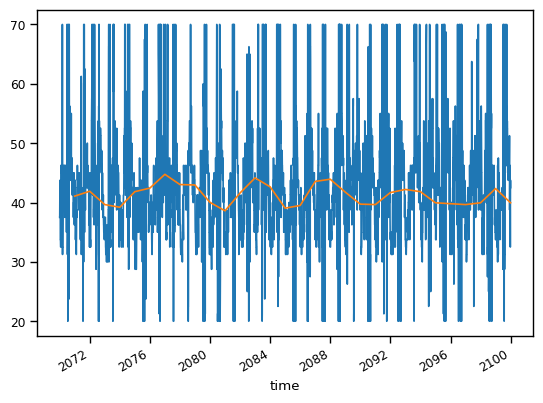

In [20]:
all_df_npac_future_dataset['Woollings et al. 2010']['HadGEM3-GC31-LL_r1i1p1f3'].dropna().plot()
all_df_npac_future_dataset['Bracegirdle et al. 2018']['HadGEM3-GC31-LL_r1i1p1f3'].dropna().plot()

In [21]:
len(all_df_npac_future_dataset['Woollings et al. 2010'].columns), len(all_df_npac_future_dataset['Barnes & Simpson 2017'].columns)

(96, 96)

#### view ensembles

In [22]:
collections.Counter([row.split('_r')[0] for row in all_df_npac_future_dataset['Woollings et al. 2010'].columns])

Counter({'CanESM5': 20,
         'MIROC-ES2L': 10,
         'MPI-ESM1-2-LR': 9,
         'UKESM1-0-LL': 7,
         'CNRM-CM6-1': 6,
         'HadGEM3-GC31-LL': 4,
         'HadGEM3-GC31-MM': 4,
         'IPSL-CM6A-LR': 3,
         'KACE-1-0-G': 3,
         'MIROC6': 3,
         'CESM2-WACCM': 3,
         'CNRM-ESM2-1': 2,
         'NESM3': 2,
         'ACCESS-ESM1-5': 2,
         'CMCC-ESM2': 1,
         'EC-Earth3-Veg-LR': 1,
         'NorESM2-LM': 1,
         'NorESM2-MM': 1,
         'EC-Earth3': 1,
         'MRI-ESM2-0': 1,
         'MPI-ESM1-2-HR': 1,
         'ACCESS-CM2': 1,
         'TaiESM1': 1,
         'EC-Earth3-CC': 1,
         'BCC-CSM2-MR': 1,
         'CMCC-CM2-SR5': 1,
         'INM-CM4-8': 1,
         'INM-CM5-0': 1,
         'FGOALS-g3': 1,
         'EC-Earth3-Veg': 1,
         'AWI-CM-1-1-MR': 1,
         'GFDL-CM4': 1})

In [23]:
# sorted(all_df_npac_future_dataset['Woollings et al. 2010'].columns, key=lambda row: row.split('_')[0])

# Load CMIP6 Historical

In [24]:
HIST_START_DATE = "1985-01-01"
HIST_END_DATE = "2015-12-31"
PERIOD_NUMBER_OF_DAYS = (pd.to_datetime(HIST_END_DATE) - pd.to_datetime(HIST_START_DATE)).days
MISSING_NUM_DAYS_THRESHOLD = 0.05 ## only allow for up to 5% less duration in data 

In [25]:
CMIP6_Historical_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_Historical_NPAC runs/outputs/ua_day*"

In [26]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Zappa et al. 2018", "Kerr et al. 2020"] #, "Barnes & Polvani 2015"
COLS_TO_REMOVE = ["10_day_average", "plev"]

region = "North Pacific"

In [27]:
print(region, len(glob.glob(CMIP6_Historical_dir + region + "*")))

North Pacific 1483


In [28]:
%%time
## takes ~65 seconds on Intel i7-10750 

time_ranges = []
failed_data_paths = []
data_paths_not_enough_days = []
date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_Historical_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except Exception as e:
#         print(e)
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    current_data_period_in_days = (pd.to_datetime(last_time) - pd.to_datetime(first_time)).days
    ## check there is enough days
    if (PERIOD_NUMBER_OF_DAYS * MISSING_NUM_DAYS_THRESHOLD) < current_data_period_in_days:
        time_ranges.append(str(first_time)+'to'+str(last_time))
    else:
        data_paths_not_enough_days.append(file_path)

CPU times: user 49.7 s, sys: 308 ms, total: 50 s
Wall time: 50.4 s


In [29]:
collections.Counter(time_ranges)

Counter({'1950-01-01to2014-12-31': 953,
         '1950-01-01to2014-12-30': 189,
         '1950-01-01to2015-01-01': 84,
         '1950-01-01to2014-12-27': 49,
         '1950-01-01to2014-12-21': 27,
         '1950-01-02to2014-12-31': 7,
         '1950-01-01to2015-12-31': 7,
         '1950-01-02to2014-12-28': 1,
         '1950-01-01to2015-12-22': 1})

In [30]:
len(data_paths_not_enough_days)

0

In [31]:
## check all failures are bracegirdle (because this is an annual metric)
all(['Bracegirdle et al. 2018' in fn for fn in failed_data_paths]), len(failed_data_paths)

(True, 165)

In [32]:
%%time
## takes ~35 seconds on Intel i7-10750 
all_df_npac_hist_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"),
                                                                                           ignored_data_paths=[])
        continue
    all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"),
                                                                       ignored_data_paths=data_paths_not_enough_days)


CPU times: user 50.7 s, sys: 188 ms, total: 50.9 s
Wall time: 50.9 s


In [33]:
all_df_npac_hist_dataset['Woollings et al. 2010'].columns

Index(['ACCESS-CM2_r1i1p1f1', 'ACCESS-ESM1-5_r32i1p1f1',
       'IPSL-CM6A-LR_r2i1p1f1', 'MIROC-ES2L_r5i1p1f2', 'CNRM-CM6-1_r8i1p1f2',
       'CESM2_r5i1p1f1', 'CNRM-CM6-1_r4i1p1f2', 'BCC-CSM2-MR_r3i1p1f1',
       'HadGEM3-GC31-MM_r1i1p1f3', 'MRI-ESM2-0_r5i1p1f1',
       ...
       'GFDL-CM4_r1i1p1f1', 'CanESM5_r1i1p2f1', 'UKESM1-0-LL_r17i1p1f2',
       'CanESM5_r8i1p2f1', 'ACCESS-ESM1-5_r21i1p1f1',
       'ACCESS-ESM1-5_r17i1p1f1', 'IPSL-CM6A-LR_r5i1p1f1',
       'INM-CM4-8_r1i1p1f1', 'IPSL-CM6A-LR_r6i1p1f1', 'UKESM1-0-LL_r15i1p1f2'],
      dtype='object', length=164)

In [34]:
set(all_df_npac_hist_dataset['Barnes & Simpson 2017'].columns).difference(set(all_df_npac_hist_dataset['Woollings et al. 2010'].columns))

{'IITM-ESM_r1i1p1f1'}

In [35]:
%%time
## takes ~600 milliseconds on Intel i7-10750 
## rerun above 2 cell if you have a problem with Bracegirlde et al. 2018
START_YEAR = HIST_START_DATE[:4] # "1950"
END_YEAR = HIST_END_DATE[:4] # "2015"
FREQ = 'd'
for metric in metric_names:
    # print(metric)
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric].index = pd.date_range(start="1950", freq="y", periods=len(all_df_npac_hist_dataset[metric])) # NOTE: START YEAR HARD CODED
        all_df_npac_hist_dataset[metric].index = all_df_npac_hist_dataset[metric].index.rename('time')
    all_df_npac_hist_dataset[metric].index = pd.to_datetime(all_df_npac_hist_dataset[metric].index, errors='coerce')
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric][START_YEAR: END_YEAR]
    if 'IITM-ESM_r1i1p1f1' in all_df_npac_hist_dataset[metric].columns:
        all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].drop('IITM-ESM_r1i1p1f1', axis=1)
        print('removed IITM-ESM_r1i1p1f1')

removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
CPU times: user 476 ms, sys: 220 ms, total: 696 ms
Wall time: 695 ms


In [36]:
len(all_df_npac_hist_dataset['Woollings et al. 2010'].columns), len(all_df_npac_hist_dataset['Barnes & Simpson 2017'].columns)

(164, 164)

In [37]:
collections.Counter([row.split('_r')[0] for row in all_df_npac_hist_dataset['Woollings et al. 2010'].columns])

Counter({'ACCESS-ESM1-5': 37,
         'CanESM5': 19,
         'UKESM1-0-LL': 17,
         'CNRM-CM6-1': 10,
         'IPSL-CM6A-LR': 9,
         'CESM2': 8,
         'MIROC-ES2L': 7,
         'MRI-ESM2-0': 5,
         'CNRM-ESM2-1': 5,
         'HadGEM3-GC31-LL': 5,
         'HadGEM3-GC31-MM': 4,
         'CESM2-WACCM': 3,
         'BCC-ESM1': 3,
         'BCC-CSM2-MR': 2,
         'GISS-E2-1-G': 2,
         'ACCESS-CM2': 1,
         'EC-Earth3-AerChem': 1,
         'TaiESM1': 1,
         'FGOALS-g3': 1,
         'MPI-ESM-1-2-HAM': 1,
         'KACE-1-0-G': 1,
         'CMCC-ESM2': 1,
         'MPI-ESM1-2-HR': 1,
         'INM-CM5-0': 1,
         'NorESM2-LM': 1,
         'CMCC-CM2-SR5': 1,
         'CMCC-CM2-HR4': 1,
         'MPI-ESM1-2-LR': 1,
         'EC-Earth3': 1,
         'IPSL-CM5A2-INCA': 1,
         'MIROC6': 1,
         'CNRM-CM6-1-HR': 1,
         'CESM2-FV2': 1,
         'AWI-ESM-1-1-LR': 1,
         'NorESM2-MM': 1,
         'FGOALS-f3-L': 1,
         'IPSL-CM6A-LR-INCA

## Load Reanalysis

In [38]:
REAN_START_DATE = "1980-01-01"
REAN_END_DATE = "2022-12-31"
REAN_START_YEAR = REAN_START_DATE[:4]
REAN_END_YEAR = REAN_END_DATE[:4]

In [39]:
era_npac_day_dict = {}

era_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# era_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[21:]##HARDCODED as starts at 1959
era_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [40]:
jra55_npac_day_dict = {}

jra55_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# jra55_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[:-1] ##HARDCODED as ends at 2023
jra55_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [41]:
merra2_npac_day_dict = {}

merra2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# merra2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
merra2_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [42]:
ncepdoe2_npac_day_dict = {}

ncepdoe2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# ncepdoe2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
ncepdoe2_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [43]:
## Check length of Bracegirlde data
len(era_npac_day_dict['Bracegirdle2018_NorthPacific']), len(jra55_npac_day_dict['Bracegirdle2018_NorthPacific']), len(merra2_npac_day_dict['Bracegirdle2018_NorthPacific']), len(ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'])

(43, 43, 43, 43)

# Calculate Jet latitude mean and trends...

In [44]:
### required functions for calculating gradient/trend and formatting data
def get_linear_reg_slope(data, col_name):
    lin_reg_data = prepare_data_for_linear_reg(data, col_name)
    return linear_reg_slope(lin_reg_data)


def prepare_data_for_linear_reg(data, col_name):
    values = data[col_name].values.astype(float)
    ordinal_dates = get_ordinal_dates(data)
    lin_reg_data = pd.DataFrame([values, ordinal_dates]).T
    lin_reg_data = lin_reg_data.dropna()
    return lin_reg_data


def get_ordinal_dates(data, index_col_name='time'):
    return pd.to_datetime(data.reset_index()[index_col_name]).apply(lambda date: date.toordinal())


def linear_reg_slope(data):
    """
        data[0] should be values, data[1] should be ordinal dates
    """
    slope, intercept = np.polyfit(data[1], data[0], 1)
    lr1d = np.poly1d([slope, intercept])(data[1])
    return pd.DataFrame(lr1d, index=data[1].apply(lambda row: pd.to_datetime(datetime.date.fromordinal(int(row)))), columns=['reg_line'])

def get_year_gradient_of_trend(data, jet_lat_name='jet_lat', proportion_threshold_for_missing_data=4):
    """
        TODO: fix ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
    """
    try:
        cdata = data.dropna()
        lin_reg_line = get_linear_reg_slope(data, jet_lat_name)
        year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
        return year_gradient
    except ValueError as ve:
        print(ve)
        pass
    try:
        assert float(data.isnull().sum(axis=0)) < (len(data)/proportion_threshold_for_missing_data)
        data = data.fillna(data.mean())
        lin_reg_line = get_linear_reg_slope(data, jet_lat_name)
        year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
        return year_gradient
    except AssertionError as ae:
        print(f"{data.name}failed. {int(data.isnull().sum(axis=0))} out of {len(data)} data points missing")
        return np.nan
    
def format_dict_to_dataframe(jet_lat_dict, unique_col_name):
    jet_lat_df = pd.DataFrame(jet_lat_dict)
    jet_lat_df = jet_lat_df.stack().reset_index()
    jet_lat_df.columns = ["Metric", "Dataset", unique_col_name]
    ## rename metric name to formatted version
    jet_lat_df['Metric'] = jet_lat_df.Metric.apply(lambda row: METRIC_LABEL_RENAMER[row])
    ## include decade trend 
    if 'trend' in unique_col_name.lower():
        jet_lat_df[unique_col_name+'_decade'] = jet_lat_df[unique_col_name]*10
    return jet_lat_df

## ... for reanalysis

In [45]:
%%time
## takes ~28 seconds on Intel i7-10750 
reanalysis_data = [era_npac_day_dict, jra55_npac_day_dict, merra2_npac_day_dict, ncepdoe2_npac_day_dict]
reanalysis_names = ["ERA-5", "JRA-55", "MERRA-2", "NCEP/DOE II"]
djf_jet_lat_mean_dict = {}
mam_jet_lat_mean_dict = {}
jja_jet_lat_mean_dict = {}
son_jet_lat_mean_dict = {}
djf_jet_lat_trend_dict = {}
mam_jet_lat_trend_dict = {}
jja_jet_lat_trend_dict = {}
son_jet_lat_trend_dict = {}
for ind, reanalysis_set in enumerate(reanalysis_data):
    reanalysis_name = reanalysis_names[ind]
    djf_jet_lat_mean_dict[reanalysis_name] = {}
    mam_jet_lat_mean_dict[reanalysis_name] = {}
    jja_jet_lat_mean_dict[reanalysis_name] = {}
    son_jet_lat_mean_dict[reanalysis_name] = {}
    djf_jet_lat_trend_dict[reanalysis_name] = {}
    mam_jet_lat_trend_dict[reanalysis_name] = {}
    jja_jet_lat_trend_dict[reanalysis_name] = {}
    son_jet_lat_trend_dict[reanalysis_name] = {}
    print(reanalysis_name)
    for metric in METRIC_DATA_NAMES:
        if metric == "Bracegirdle2018_NorthPacific":
            ## ignore because only calculated by annual scale
            continue
        else:
            reanalysis_set[metric].index = pd.to_datetime(reanalysis_set[metric].index)
            djf_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([12, 1, 2])]['jet_lat'].mean())
            mam_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([3, 4, 5])]['jet_lat'].mean())
            jja_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([6, 7, 8])]['jet_lat'].mean())
            son_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([9, 10, 11])]['jet_lat'].mean())
   
            djf_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([12, 1, 2])])
            mam_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([3, 4, 5])])
            jja_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([6, 7, 8])])
            son_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([9, 10, 11])])

ERA-5
JRA-55
MERRA-2
NCEP/DOE II
CPU times: user 25.5 s, sys: 3.98 ms, total: 25.5 s
Wall time: 25.5 s


In [46]:
djf_jet_lat_mean_df = format_dict_to_dataframe(djf_jet_lat_mean_dict, "DJF Mean")
djf_jet_lat_trend_df = format_dict_to_dataframe(djf_jet_lat_trend_dict, "DJF Trend")

mam_jet_lat_mean_df = format_dict_to_dataframe(mam_jet_lat_mean_dict, "MAM Mean")
mam_jet_lat_trend_df = format_dict_to_dataframe(mam_jet_lat_trend_dict, "MAM Trend")

jja_jet_lat_mean_df = format_dict_to_dataframe(jja_jet_lat_mean_dict, "JJA Mean")
jja_jet_lat_trend_df = format_dict_to_dataframe(jja_jet_lat_trend_dict, "JJA Trend")

son_jet_lat_mean_df = format_dict_to_dataframe(son_jet_lat_mean_dict, "SON Mean")
son_jet_lat_trend_df = format_dict_to_dataframe(son_jet_lat_trend_dict, "SON Trend")

In [47]:
## merge all
allseasons_jet_lat_mean_df = djf_jet_lat_mean_df.merge(mam_jet_lat_mean_df)
allseasons_jet_lat_mean_df = allseasons_jet_lat_mean_df.merge(jja_jet_lat_mean_df)
allseasons_jet_lat_mean_df = allseasons_jet_lat_mean_df.merge(son_jet_lat_mean_df)

allseasons_jet_lat_trend_df = djf_jet_lat_trend_df.merge(mam_jet_lat_trend_df)
allseasons_jet_lat_trend_df = allseasons_jet_lat_trend_df.merge(jja_jet_lat_trend_df)
allseasons_jet_lat_trend_df = allseasons_jet_lat_trend_df.merge(son_jet_lat_trend_df)

all_seasons_rean_jet_lat_mean_and_trend_df = allseasons_jet_lat_mean_df.merge(allseasons_jet_lat_trend_df)

In [48]:
all_seasons_rean_jet_lat_mean_and_trend_df.head()

,Metric,Dataset,DJF Mean,MAM Mean,JJA Mean,SON Mean,DJF Trend,DJF Trend_decade,MAM Trend,MAM Trend_decade,JJA Trend,JJA Trend_decade,SON Trend,SON Trend_decade
0,Woollings et al. 2010,ERA-5,38.366658,41.389493,46.509317,45.757195,0.091208,0.912078,0.026323,0.263228,0.044241,0.442414,-0.013672,-0.136715
1,Woollings et al. 2010,JRA-55,38.411569,41.420807,46.809330,45.812075,0.076927,0.769266,0.025799,0.257988,0.063805,0.638047,0.001078,0.010777
2,Woollings et al. 2010,MERRA-2,38.401064,41.398680,46.062699,45.692318,0.068468,0.684678,0.007373,0.073727,0.036818,0.368179,0.000604,0.006043
3,Woollings et al. 2010,NCEP/DOE II,38.296543,41.183359,46.412396,45.794741,0.072824,0.728244,0.010188,0.101878,0.022320,0.223199,-0.007454,-0.074542
4,Barnes & Polvani 2013,ERA-5,38.491300,41.477218,46.296284,45.798053,0.093136,0.931359,0.026093,0.260933,0.041037,0.410372,-0.014863,-0.148630


## .. for CMIP6 Historical

In [ ]:
%%time
## takes ~16 minutes on Intel i7-10750 

hist_djf_jet_lat_mean_dict = {}
hist_mam_jet_lat_mean_dict = {}
hist_jja_jet_lat_mean_dict = {}
hist_son_jet_lat_mean_dict = {}

hist_djf_jet_lat_trend_dict = {}
hist_mam_jet_lat_trend_dict = {}
hist_jja_jet_lat_trend_dict = {}
hist_son_jet_lat_trend_dict = {}

for metric in metric_names:
    print(metric)
    if metric == "Bracegirdle et al. 2018":
        ## ignore because only calculated by annual scale
        continue
    hist_djf_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([12, 1, 2])].mean()
    hist_mam_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([3, 4, 5])].mean()
    hist_jja_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([6, 7, 8])].mean()
    hist_son_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([9, 10, 11])].mean()
    
    hist_djf_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([12, 1, 2])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_mam_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([3, 4, 5])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_jja_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([6, 7, 8])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_son_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([9, 10, 11])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)

Woollings et al. 2010
Barnes & Polvani 2013
Barnes & Simpson 2017
Grise & Polvani 2017
Bracegirdle et al. 2018
Zappa et al. 2018


In [ ]:
hist_djf_jet_lat_trend_dict['Woollings et al. 2010']

In [ ]:
hist_djf_jet_lat_mean_df = pd.concat(hist_djf_jet_lat_mean_dict, axis=1)
hist_mam_jet_lat_mean_df = pd.concat(hist_mam_jet_lat_mean_dict, axis=1)
hist_jja_jet_lat_mean_df = pd.concat(hist_jja_jet_lat_mean_dict, axis=1)
hist_son_jet_lat_mean_df = pd.concat(hist_son_jet_lat_mean_dict, axis=1)

hist_djf_jet_lat_trend_df = pd.concat(hist_djf_jet_lat_trend_dict, axis=1)
hist_mam_jet_lat_trend_df = pd.concat(hist_mam_jet_lat_trend_dict, axis=1)
hist_jja_jet_lat_trend_df = pd.concat(hist_jja_jet_lat_trend_dict, axis=1)
hist_son_jet_lat_trend_df = pd.concat(hist_son_jet_lat_trend_dict, axis=1)

In [ ]:
hist_djf_jet_lat_trend_df.head()

In [ ]:
hist_djf_jet_lat_trend_df.plot();

## .. for CMIP6 SSP5-8.5

In [ ]:
%%time
## takes ~4 minutes on Intel i7-10750 
ssp585_djf_jet_lat_mean_dict = {}
ssp585_mam_jet_lat_mean_dict = {}
ssp585_jja_jet_lat_mean_dict = {}
ssp585_son_jet_lat_mean_dict = {}

ssp585_djf_jet_lat_trend_dict = {}
ssp585_mam_jet_lat_trend_dict = {}
ssp585_jja_jet_lat_trend_dict = {}
ssp585_son_jet_lat_trend_dict = {}

for metric in metric_names:
    print(metric)
    if metric == "Bracegirdle et al. 2018":
        ## ignore because only calculated by annual scale
        continue
    ssp585_djf_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([12, 1, 2])].mean()
    ssp585_mam_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([3, 4, 5])].mean()
    ssp585_jja_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([6, 7, 8])].mean()
    ssp585_son_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([9, 10, 11])].mean()
    
    ssp585_djf_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([12, 1, 2])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    ssp585_mam_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([3, 4, 5])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    ssp585_jja_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([6, 7, 8])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    ssp585_son_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([9, 10, 11])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)

In [ ]:
ssp585_djf_jet_lat_mean_df = pd.concat(ssp585_djf_jet_lat_mean_dict, axis=1)
ssp585_mam_jet_lat_mean_df = pd.concat(ssp585_mam_jet_lat_mean_dict, axis=1)
ssp585_jja_jet_lat_mean_df = pd.concat(ssp585_jja_jet_lat_mean_dict, axis=1)
ssp585_son_jet_lat_mean_df = pd.concat(ssp585_son_jet_lat_mean_dict, axis=1)

ssp585_djf_jet_lat_trend_df = pd.concat(ssp585_djf_jet_lat_trend_dict, axis=1)
ssp585_mam_jet_lat_trend_df = pd.concat(ssp585_mam_jet_lat_trend_dict, axis=1)
ssp585_jja_jet_lat_trend_df = pd.concat(ssp585_jja_jet_lat_trend_dict, axis=1)
ssp585_son_jet_lat_trend_df = pd.concat(ssp585_son_jet_lat_trend_dict, axis=1)

In [ ]:
ssp585_djf_jet_lat_trend_df.head()

In [ ]:
ssp585_djf_jet_lat_trend_df.plot()

# Combine data

In [ ]:
all_seasons_rean_jet_lat_mean_and_trend_df = all_seasons_rean_jet_lat_mean_and_trend_df.loc[~(all_seasons_rean_jet_lat_mean_and_trend_df.Metric == "Bracegirdle et al. 2018")]

In [ ]:
# SEASON_TO_LOOK_AT = 'DJF' # 'DJF'

In [586]:
djf_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='DJF Mean')
djf_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='DJF Trend_decade')

mam_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='MAM Mean')
mam_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='MAM Trend_decade')

jja_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='JJA Mean')
jja_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='JJA Trend_decade')

son_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='SON Mean')
son_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='SON Trend_decade')

In [587]:
djf_all_rean_mean

Metric,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2017,Kerr et al. 2020,Woollings et al. 2010,Zappa et al. 2018
Dataset,,,,,,
ERA-5,38.491300,37.560526,39.262580,40.912466,38.366658,38.185045
JRA-55,38.483448,37.378289,39.184255,40.868328,38.411569,38.294532
MERRA-2,38.545687,37.627632,39.341559,41.368274,38.401064,38.332956
NCEP/DOE II,38.356249,37.348684,38.901179,40.398150,38.296543,38.201884


In [588]:
djf_all_rean_mean = djf_all_rean_mean[sorted(djf_all_rean_mean.columns, key=lambda x: x[-4:])]
djf_all_rean_trend = djf_all_rean_trend[sorted(djf_all_rean_trend.columns, key=lambda x: x[-4:])]

mam_all_rean_mean = mam_all_rean_mean[sorted(mam_all_rean_mean.columns, key=lambda x: x[-4:])]
mam_all_rean_trend = mam_all_rean_trend[sorted(mam_all_rean_trend.columns, key=lambda x: x[-4:])]

jja_all_rean_mean = jja_all_rean_mean[sorted(jja_all_rean_mean.columns, key=lambda x: x[-4:])]
jja_all_rean_trend = jja_all_rean_trend[sorted(jja_all_rean_trend.columns, key=lambda x: x[-4:])]

son_all_rean_mean = son_all_rean_mean[sorted(son_all_rean_mean.columns, key=lambda x: x[-4:])]
son_all_rean_trend = son_all_rean_trend[sorted(son_all_rean_trend.columns, key=lambda x: x[-4:])]

#### sort index by minimum difference from reanalysis mean across all metrics

In [550]:
sorted_index_by_minimum_error_from_reanalysis_mean_djf = abs(hist_djf_jet_lat_mean_df -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index
sorted_index_by_minimum_error_from_reanalysis_trends_djf = abs(hist_djf_jet_lat_trend_df -  djf_all_rean_trend.mean())\
                                                    .sum(axis=1).sort_values().index

sorted_index_by_minimum_error_from_reanalysis_mean_djf = abs(hist_djf_jet_lat_mean_df -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index
sorted_index_by_minimum_error_from_reanalysis_trends_djf = abs(hist_djf_jet_lat_trend_df -  djf_all_rean_trend.mean())\
                                                    .sum(axis=1).sort_values().index

sorted_index_by_minimum_error_from_reanalysis_mean_djf = abs(hist_djf_jet_lat_mean_df -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index
sorted_index_by_minimum_error_from_reanalysis_trends_djf = abs(hist_djf_jet_lat_trend_df -  djf_all_rean_trend.mean())\
                                                    .sum(axis=1).sort_values().index

sorted_index_by_minimum_error_from_reanalysis_mean_djf = abs(hist_djf_jet_lat_mean_df -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index
sorted_index_by_minimum_error_from_reanalysis_trends_djf = abs(hist_djf_jet_lat_trend_df -  djf_all_rean_trend.mean())\
                                                    .sum(axis=1).sort_values().index

In [551]:
hist_djf_jet_lat_mean_df = hist_djf_jet_lat_mean_df.loc[sorted_index_by_minimum_error_from_reanalysis_mean]
hist_djf_jet_lat_trend_df = hist_djf_jet_lat_trend_df.loc[sorted_index_by_minimum_error_from_reanalysis_trends]

#### join to reanalysis

In [552]:
djf_hist_and_rean_mean = pd.concat([djf_all_rean_mean, hist_djf_jet_lat_mean_df])
djf_hist_and_rean_trend = pd.concat([djf_all_rean_trend, hist_djf_jet_lat_trend_df])


### join to ssp585

In [553]:
djf_hist_rean_and_future_mean = pd.concat([djf_hist_and_rean_mean, ssp585_djf_jet_lat_mean_df], axis=1)
djf_hist_rean_and_future_trend = pd.concat([djf_hist_and_rean_trend, ssp585_djf_jet_lat_trend_df], axis=1)

In [554]:
djf_hist_and_rean_mean.index

Index(['ERA-5', 'JRA-55', 'MERRA-2', 'NCEP/DOE II', 'ACCESS-CM2_r1i1p1f1',
       'FGOALS-g3_r1i1p1f1', 'MIROC-ES2L_r4i1p1f2', 'MIROC-ES2L_r5i1p1f2',
       'ACCESS-ESM1-5_r19i1p1f1', 'ACCESS-ESM1-5_r26i1p1f1',
       ...
       'CESM2_r2i1p1f1', 'EC-Earth3-AerChem_r1i1p1f1', 'CESM2-FV2_r1i1p1f1',
       'NorESM2-LM_r1i1p1f1', 'AWI-ESM-1-1-LR_r1i1p1f1',
       'MPI-ESM-1-2-HAM_r1i1p1f1', 'CMCC-CM2-HR4_r1i1p1f1', 'NESM3_r1i1p1f1',
       'GISS-E2-1-G_r1i1p1f1', 'GISS-E2-1-G_r1i1p1f2'],
      dtype='object', length=168)

<Axes: >

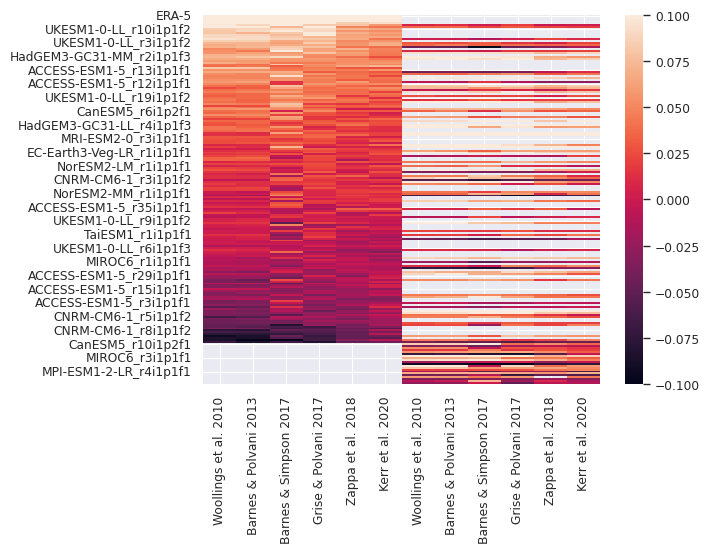

In [555]:
sns.heatmap(djf_hist_rean_and_future_trend)

In [556]:
set(hist_djf_jet_lat_mean_df.index).intersection(set(ssp585_djf_jet_lat_mean_df.index))

{'ACCESS-CM2_r1i1p1f1',
 'ACCESS-ESM1-5_r2i1p1f1',
 'ACCESS-ESM1-5_r3i1p1f1',
 'CESM2-WACCM_r1i1p1f1',
 'CESM2-WACCM_r2i1p1f1',
 'CESM2-WACCM_r3i1p1f1',
 'CMCC-CM2-SR5_r1i1p1f1',
 'CMCC-ESM2_r1i1p1f1',
 'CNRM-CM6-1_r1i1p1f2',
 'CNRM-CM6-1_r2i1p1f2',
 'CNRM-CM6-1_r3i1p1f2',
 'CNRM-CM6-1_r4i1p1f2',
 'CNRM-CM6-1_r5i1p1f2',
 'CNRM-CM6-1_r6i1p1f2',
 'CNRM-ESM2-1_r4i1p1f2',
 'CNRM-ESM2-1_r5i1p1f2',
 'CanESM5_r10i1p1f1',
 'CanESM5_r1i1p1f1',
 'CanESM5_r1i1p2f1',
 'CanESM5_r2i1p1f1',
 'CanESM5_r2i1p2f1',
 'CanESM5_r3i1p1f1',
 'CanESM5_r3i1p2f1',
 'CanESM5_r4i1p1f1',
 'CanESM5_r4i1p2f1',
 'CanESM5_r5i1p1f1',
 'CanESM5_r5i1p2f1',
 'CanESM5_r6i1p1f1',
 'CanESM5_r6i1p2f1',
 'CanESM5_r7i1p1f1',
 'CanESM5_r7i1p2f1',
 'CanESM5_r8i1p1f1',
 'CanESM5_r8i1p2f1',
 'CanESM5_r9i1p1f1',
 'CanESM5_r9i1p2f1',
 'EC-Earth3-CC_r1i1p1f1',
 'EC-Earth3-Veg-LR_r1i1p1f1',
 'EC-Earth3_r1i1p1f1',
 'FGOALS-g3_r1i1p1f1',
 'GFDL-CM4_r1i1p1f1',
 'HadGEM3-GC31-LL_r1i1p1f3',
 'HadGEM3-GC31-LL_r2i1p1f3',
 'HadGEM3-GC31-LL_r3i1

## CMIP6 Future Difference instead of absolute 

In [557]:
for metric in METRIC_NAMES:
    if metric == "Bracegirdle et al. 2018":
        continue
    if metric == "Woollings et al. 2010":
        ## i.e. if first value init the overall dataframe
        metric_future_mean_diff = pd.DataFrame(djf_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
        
        metric_future_trend_diff = pd.DataFrame(djf_hist_rean_and_future_trend[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_trend[metric].index, columns=[metric+"_diff"])
        
        continue
    current_data_mean = pd.DataFrame(djf_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
    
    current_data_trends = pd.DataFrame(djf_hist_rean_and_future_trend[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_trend[metric].index, columns=[metric+"_diff"])
    
    metric_future_mean_diff = pd.concat([metric_future_mean_diff, current_data_mean], axis=1)
    metric_future_trend_diff = pd.concat([metric_future_trend_diff, current_data_trends], axis=1)

In [558]:
mean_diff_data = metric_future_mean_diff.dropna(how='all')

<Axes: >

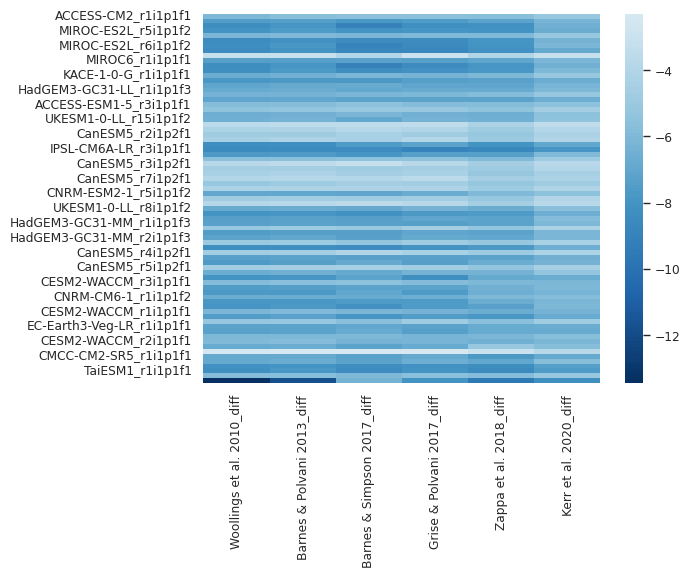

In [559]:
sns.heatmap(mean_diff_data, center=0, cmap='RdBu_r')

In [560]:
# djf_hist_rean_and_future_mean.to_csv('outputs/djf_hist_rean_future_mean.csv')
# djf_hist_rean_and_future_trend.to_csv('outputs/djf_hist_rean_future_trend.csv')

In [561]:
# pd.read_csv('outputs/djf_hist_rean_future_mean.csv')

# Make Figure 4

In [562]:
djf_hist_and_future_mean_diffs = metric_future_mean_diff[metric_future_mean_diff.columns[-6:]].iloc[4:]
djf_hist_and_future_mean_diffs_w_mean = pd.concat([djf_hist_and_future_mean_diffs.mean(axis=1), djf_hist_and_future_mean_diffs], axis=1)
djf_hist_and_future_mean_diffs_w_mean.columns = ["Mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
                                                    "Barnes & Simpson 2017", "Grise & Polvani 2017",\
                                                   "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
djf_hist_and_future_mean_diffs_w_mean = djf_hist_and_future_mean_diffs_w_mean.dropna() 
djf_hist_and_future_mean_diffs_w_mean.head()

,Mean,Woollings et al. 2010,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2017,Zappa et al. 2018,Kerr et al. 2020
ACCESS-CM2_r1i1p1f1,-5.650178,-5.997504,-5.777810,-5.649385,-5.657719,-5.692278,-5.126372
FGOALS-g3_r1i1p1f1,-7.331042,-7.510309,-7.468247,-7.828797,-7.640775,-7.239048,-6.299079
MIROC-ES2L_r4i1p1f2,-8.023172,-8.341684,-7.872672,-9.050099,-8.229818,-8.134332,-6.510426
MIROC-ES2L_r5i1p1f2,-7.729085,-8.030503,-7.568651,-8.082421,-7.999784,-8.041544,-6.651605
ACCESS-ESM1-5_r2i1p1f1,-5.913002,-6.113793,-5.967544,-6.196345,-5.967737,-5.995340,-5.237250


In [563]:
djf_hist_and_future_mean_diffs_w_mean.columns

Index(['Mean', 'Woollings et al. 2010', 'Barnes & Polvani 2013',
       'Barnes & Simpson 2017', 'Grise & Polvani 2017', 'Zappa et al. 2018',
       'Kerr et al. 2020'],
      dtype='object')

In [564]:
djf_hist_and_future_trend_diffs = metric_future_trend_diff[metric_future_trend_diff.columns[-6:]].iloc[4:]
djf_hist_and_future_trend_diffs_w_mean = pd.concat([djf_hist_and_future_trend_diffs.mean(axis=1), djf_hist_and_future_trend_diffs], axis=1)
djf_hist_and_future_trend_diffs_w_mean.columns = ["Mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
                                                    "Barnes & Simpson 2017", "Grise & Polvani 2017",\
                                                   "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
djf_hist_and_future_trend_diffs_w_mean = djf_hist_and_future_trend_diffs_w_mean.dropna()
djf_hist_and_future_trend_diffs_w_mean.head()

,Mean,Woollings et al. 2010,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2017,Zappa et al. 2018,Kerr et al. 2020
MIROC-ES2L_r8i1p1f2,-0.099311,-0.091785,-0.076908,-0.222944,-0.063937,-0.082767,-0.057526
MIROC-ES2L_r2i1p1f2,-0.061756,-0.094184,-0.083544,-0.049473,-0.092914,-0.027074,-0.023347
CESM2-WACCM_r3i1p1f1,-0.073109,-0.094168,-0.091275,-0.098041,-0.076146,-0.045831,-0.033191
UKESM1-0-LL_r3i1p1f2,-0.047560,-0.044067,-0.047270,-0.030474,-0.068277,-0.049707,-0.045569
CanESM5_r8i1p1f1,-0.029158,-0.030465,-0.025610,-0.033196,-0.028348,-0.022343,-0.034983


/home/thomaskeel/miniconda3/envs/jsanalysis/lib/python3.11/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


<Axes: >

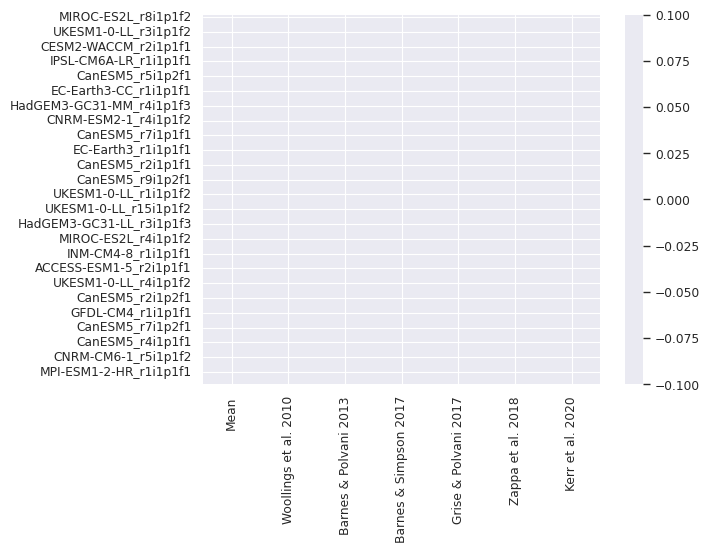

In [565]:
sns.heatmap(djf_hist_and_future_trend_diffs_w_mean, cmap='RdBu_r', center=0)

In [566]:
djf_hist_and_future_mean_diffs_w_mean_ensemble_means = djf_hist_and_future_mean_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()
djf_hist_and_future_trend_diffs_w_mean_ensemble_means = djf_hist_and_future_trend_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()

In [567]:
## find closest to reanalysis ensemble mean
djf_index_only_projs_for_sorting = djf_hist_rean_and_future_mean.dropna(how='any', axis=0).index
djf_hist_where_proj_also_vals = hist_djf_jet_lat_mean_df.loc[djf_index_only_projs_for_sorting]

In [568]:
djf_hist_where_proj_also_vals_ens_means = djf_hist_where_proj_also_vals.groupby(lambda row: row.split('_')[0]).mean()

In [569]:
sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean = abs(djf_hist_where_proj_also_vals_ens_means -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index

In [570]:
sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean

Index(['ACCESS-CM2', 'FGOALS-g3', 'MIROC-ES2L', 'MIROC6', 'ACCESS-ESM1-5',
       'KACE-1-0-G', 'MRI-ESM2-0', 'GFDL-CM4', 'IPSL-CM6A-LR',
       'HadGEM3-GC31-LL', 'CanESM5', 'UKESM1-0-LL', 'CNRM-ESM2-1',
       'CNRM-CM6-1', 'HadGEM3-GC31-MM', 'CESM2-WACCM', 'CMCC-ESM2',
       'INM-CM5-0', 'EC-Earth3-Veg-LR', 'EC-Earth3-CC', 'EC-Earth3',
       'NorESM2-MM', 'INM-CM4-8', 'CMCC-CM2-SR5', 'MPI-ESM1-2-LR',
       'MPI-ESM1-2-HR', 'TaiESM1', 'NorESM2-LM', 'NESM3'],
      dtype='object')

In [571]:
df_hist_season_by_cmip6_model_cmip6data = pd.concat([hist_djf_jet_lat_mean_df.mean(axis=1), hist_mam_jet_lat_mean_df.mean(axis=1),\
           hist_jja_jet_lat_mean_df.mean(axis=1), hist_son_jet_lat_mean_df.mean(axis=1)], axis=1)

df_hist_season_by_metric_cmip6data = pd.concat([hist_djf_jet_lat_mean_df.mean(axis=0), hist_mam_jet_lat_mean_df.mean(axis=0),\
           hist_jja_jet_lat_mean_df.mean(axis=0), hist_son_jet_lat_mean_df.mean(axis=0)], axis=1)


df_future_season_by_cmip6_model_cmip6data = pd.concat([ssp585_djf_jet_lat_mean_df.mean(axis=1), ssp585_mam_jet_lat_mean_df.mean(axis=1),\
           ssp585_jja_jet_lat_mean_df.mean(axis=1), ssp585_son_jet_lat_mean_df.mean(axis=1)], axis=1)

df_future_season_by_metric_cmip6data = pd.concat([ssp585_djf_jet_lat_mean_df.mean(axis=0), ssp585_mam_jet_lat_mean_df.mean(axis=0),\
           ssp585_jja_jet_lat_mean_df.mean(axis=0), ssp585_son_jet_lat_mean_df.mean(axis=0)], axis=1)


df_future_hist_diff_season_by_model = df_future_season_by_cmip6_model_cmip6data - df_hist_season_by_cmip6_model_cmip6data
df_future_hist_diff_season_by_metric = df_future_season_by_metric_cmip6data - df_hist_season_by_metric_cmip6data


# df_future_hist_diff_season_by_model = pd.concat([df_future_hist_diff_season_by_model.mean(axis=1), df_future_hist_diff_season_by_model], axis=1)
# df_future_hist_diff_season_by_metric = pd.concat([df_future_hist_diff_season_by_metric.mean(axis=1), df_future_hist_diff_season_by_metric], axis=1)

df_future_hist_diff_season_by_model.columns = ['DJF', 'MAM', 'JJA', 'SON']
df_future_hist_diff_season_by_metric.columns = ['DJF', 'MAM', 'JJA', 'SON']


In [572]:
df_diff_djf = ssp585_djf_jet_lat_mean_df - hist_djf_jet_lat_mean_df 
df_diff_mam = ssp585_mam_jet_lat_mean_df - hist_mam_jet_lat_mean_df
df_diff_jja = ssp585_jja_jet_lat_mean_df - hist_jja_jet_lat_mean_df
df_diff_son = ssp585_son_jet_lat_mean_df - hist_son_jet_lat_mean_df

In [573]:
df_future_hist_diff_season_by_model['Annual Mean'] = df_future_hist_diff_season_by_model.mean(axis=1)
df_future_hist_diff_season_by_metric['Annual Mean'] = df_future_hist_diff_season_by_metric.mean(axis=1)

In [574]:
df_diff_djf_ens_mean = df_diff_djf.groupby(lambda row: row.split('_')[0]).mean()
df_diff_mam_ens_mean = df_diff_mam.groupby(lambda row: row.split('_')[0]).mean()
df_diff_jja_ens_mean = df_diff_jja.groupby(lambda row: row.split('_')[0]).mean()
df_diff_son_ens_mean = df_diff_son.groupby(lambda row: row.split('_')[0]).mean()

In [575]:
models_in_groups_in_future = [model for model in df_diff_djf.dropna().index if model.split('_')[0] in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean]
model_realisation_counts = collections.Counter([model_name.split('_')[0] for model_name in models_in_groups_in_future])

In [576]:
model_realisation_counts

Counter({'CanESM5': 19,
         'MIROC-ES2L': 7,
         'CNRM-CM6-1': 6,
         'UKESM1-0-LL': 6,
         'HadGEM3-GC31-LL': 4,
         'HadGEM3-GC31-MM': 4,
         'CESM2-WACCM': 3,
         'IPSL-CM6A-LR': 3,
         'ACCESS-ESM1-5': 2,
         'CNRM-ESM2-1': 2,
         'ACCESS-CM2': 1,
         'CMCC-CM2-SR5': 1,
         'CMCC-ESM2': 1,
         'EC-Earth3-CC': 1,
         'EC-Earth3-Veg-LR': 1,
         'EC-Earth3': 1,
         'FGOALS-g3': 1,
         'GFDL-CM4': 1,
         'INM-CM4-8': 1,
         'INM-CM5-0': 1,
         'KACE-1-0-G': 1,
         'MIROC6': 1,
         'MPI-ESM1-2-HR': 1,
         'MPI-ESM1-2-LR': 1,
         'MRI-ESM2-0': 1,
         'NESM3': 1,
         'NorESM2-LM': 1,
         'NorESM2-MM': 1,
         'TaiESM1': 1})

In [577]:
models_in_groups_in_future

['ACCESS-CM2_r1i1p1f1',
 'ACCESS-ESM1-5_r2i1p1f1',
 'ACCESS-ESM1-5_r3i1p1f1',
 'CESM2-WACCM_r1i1p1f1',
 'CESM2-WACCM_r2i1p1f1',
 'CESM2-WACCM_r3i1p1f1',
 'CMCC-CM2-SR5_r1i1p1f1',
 'CMCC-ESM2_r1i1p1f1',
 'CNRM-CM6-1_r1i1p1f2',
 'CNRM-CM6-1_r2i1p1f2',
 'CNRM-CM6-1_r3i1p1f2',
 'CNRM-CM6-1_r4i1p1f2',
 'CNRM-CM6-1_r5i1p1f2',
 'CNRM-CM6-1_r6i1p1f2',
 'CNRM-ESM2-1_r4i1p1f2',
 'CNRM-ESM2-1_r5i1p1f2',
 'CanESM5_r10i1p1f1',
 'CanESM5_r1i1p1f1',
 'CanESM5_r1i1p2f1',
 'CanESM5_r2i1p1f1',
 'CanESM5_r2i1p2f1',
 'CanESM5_r3i1p1f1',
 'CanESM5_r3i1p2f1',
 'CanESM5_r4i1p1f1',
 'CanESM5_r4i1p2f1',
 'CanESM5_r5i1p1f1',
 'CanESM5_r5i1p2f1',
 'CanESM5_r6i1p1f1',
 'CanESM5_r6i1p2f1',
 'CanESM5_r7i1p1f1',
 'CanESM5_r7i1p2f1',
 'CanESM5_r8i1p1f1',
 'CanESM5_r8i1p2f1',
 'CanESM5_r9i1p1f1',
 'CanESM5_r9i1p2f1',
 'EC-Earth3-CC_r1i1p1f1',
 'EC-Earth3-Veg-LR_r1i1p1f1',
 'EC-Earth3_r1i1p1f1',
 'FGOALS-g3_r1i1p1f1',
 'GFDL-CM4_r1i1p1f1',
 'HadGEM3-GC31-LL_r1i1p1f3',
 'HadGEM3-GC31-LL_r2i1p1f3',
 'HadGEM3-GC31-LL_r3i1

In [578]:
multi_r_models = pd.DataFrame()
counter = 0
for model_name in model_realisation_counts.keys():
    if model_realisation_counts[model_name] > 1 and model_name in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean:
        # print(model_name,  model_realisation_counts[model_name])
        all_models_in_group = df_diff_djf.loc[df_diff_djf.index.str.startswith(model_name)].dropna()
        if counter == 0:
            multi_r_models[model_name] = all_models_in_group.values.flatten()
        else:
            current_mgroup = pd.Series(all_models_in_group.values.flatten(), name=model_name)
            
            multi_r_models = pd.concat([multi_r_models, current_mgroup], axis=1)
        counter+=1
    

In [579]:
multi_r_models.head()

,ACCESS-ESM1-5,CESM2-WACCM,CNRM-CM6-1,CNRM-ESM2-1,CanESM5,HadGEM3-GC31-LL,HadGEM3-GC31-MM,IPSL-CM6A-LR,MIROC-ES2L,UKESM1-0-LL
0,-6.113793,-6.138243,-6.725569,-7.543761,-4.312160,-6.772794,-7.304886,-7.072922,-8.395456,-6.504411
1,-5.967544,-5.972785,-6.694245,-7.407388,-4.156534,-6.613697,-7.151754,-6.945340,-8.052295,-6.408308
2,-6.196345,-6.202407,-6.824360,-7.201867,-4.175452,-6.967593,-7.288100,-6.743484,-8.719138,-6.962963
3,-5.967737,-6.361236,-6.539140,-7.201620,-4.141648,-6.787364,-7.350332,-7.059549,-8.813192,-6.348756
4,-5.995340,-6.696503,-6.064955,-6.505882,-4.911534,-6.780150,-7.151515,-7.119336,-8.169433,-6.496404


In [580]:
## make dataset correct size for plotting
model_name_df = pd.DataFrame(df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean].T.columns)
model_name_df.index= model_name_df[0]
model_name_df[0] = np.nan
model_name_df = model_name_df.rename(columns={0:'remove_col'})
multi_r_models_w_all_models = pd.concat([model_name_df.T, multi_r_models])
multi_r_models_w_all_models = multi_r_models_w_all_models.drop('remove_col')
multi_r_models_w_all_models.head()

,ACCESS-CM2,FGOALS-g3,MIROC-ES2L,MIROC6,ACCESS-ESM1-5,KACE-1-0-G,MRI-ESM2-0,GFDL-CM4,IPSL-CM6A-LR,HadGEM3-GC31-LL,...,EC-Earth3-CC,EC-Earth3,NorESM2-MM,INM-CM4-8,CMCC-CM2-SR5,MPI-ESM1-2-LR,MPI-ESM1-2-HR,TaiESM1,NorESM2-LM,NESM3
0,NaN,NaN,-8.395456,NaN,-6.113793,NaN,NaN,NaN,-7.072922,-6.772794,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,-8.052295,NaN,-5.967544,NaN,NaN,NaN,-6.945340,-6.613697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,-8.719138,NaN,-6.196345,NaN,NaN,NaN,-6.743484,-6.967593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,-8.813192,NaN,-5.967737,NaN,NaN,NaN,-7.059549,-6.787364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,-8.169433,NaN,-5.995340,NaN,NaN,NaN,-7.119336,-6.780150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/home/thomaskeel/miniconda3/envs/jsanalysis/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


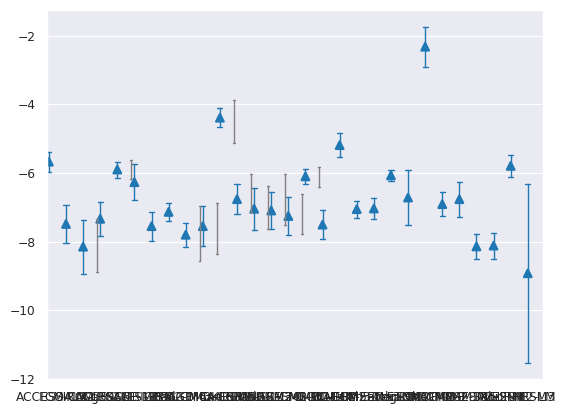

In [581]:
# help from: https://stackoverflow.com/questions/46486934/seaborn-pointplot-and-boxplot-in-one-plot-but-shifted-on-the-x-axis
fig, ax = plt.subplots(1)
estimator_to_use = 'median'
sns.pointplot(df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean].T, errorbar=('sd', 1),  capsize=.3, estimator=estimator_to_use,\
              markers = '^', errwidth=1, join=False, ax=ax)
offset = matplotlib.transforms.ScaledTranslation(-(5/72.), 0, ax.figure.dpi_scale_trans)
trans = ax.collections[0].get_transform()
ax.collections[0].set_transform(trans + offset)
for line in ax.lines:
    trans = line.get_transform()
    line.set_transform(trans + offset)
    
sns.pointplot(multi_r_models_w_all_models, errorbar=('sd', 1),  capsize=.1, estimator=estimator_to_use,\
              markers='', errwidth=1, join=False, color='.5',  ax=ax);

offset = matplotlib.transforms.ScaledTranslation(5/72., 0, ax.figure.dpi_scale_trans)
trans = ax.collections[1].get_transform()
ax.collections[1].set_transform(trans + offset)
for line in ax.lines[len(ax.lines)//2:]:
    trans = line.get_transform()
    line.set_transform(trans + offset)

In [582]:
## DROP PROBLEMATIC NESM1

In [583]:
if 'NESM3' in df_diff_son_ens_mean.index:
    print('dropping NESM3')
    df_diff_djf_ens_mean = df_diff_djf_ens_mean.drop('NESM3')
    df_future_hist_diff_season_by_model = df_future_hist_diff_season_by_model.drop('NESM3_r1i1p1f1')
    df_future_hist_diff_season_by_model = df_future_hist_diff_season_by_model.drop('NESM3_r2i1p1f1')
    djf_hist_and_future_mean_diffs_w_mean_ensemble_means = djf_hist_and_future_mean_diffs_w_mean_ensemble_means.drop('NESM3')
    multi_r_models_w_all_models = multi_r_models_w_all_models.drop('NESM3', axis=1)
    sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean.drop('NESM3')

dropping NESM3


In [584]:
# add number to each model name column
# df_diff_djf_ens_mean_with_groupcount = df_diff_djf_ens_mean.copy()
sorted_models_with_group_count = []
for model_name in df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean].index:
    if model_realisation_counts[model_name] > 1:
        sorted_models_with_group_count.append(f'{model_name} ({model_realisation_counts[model_name]})')
    else:
        sorted_models_with_group_count.append(model_name)

/home/thomaskeel/miniconda3/envs/jsanalysis/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7), (0.7, 0.7, 0.7)]) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


Text(-0.6, -1.2, 'SSP5-8.5 vs Historical')

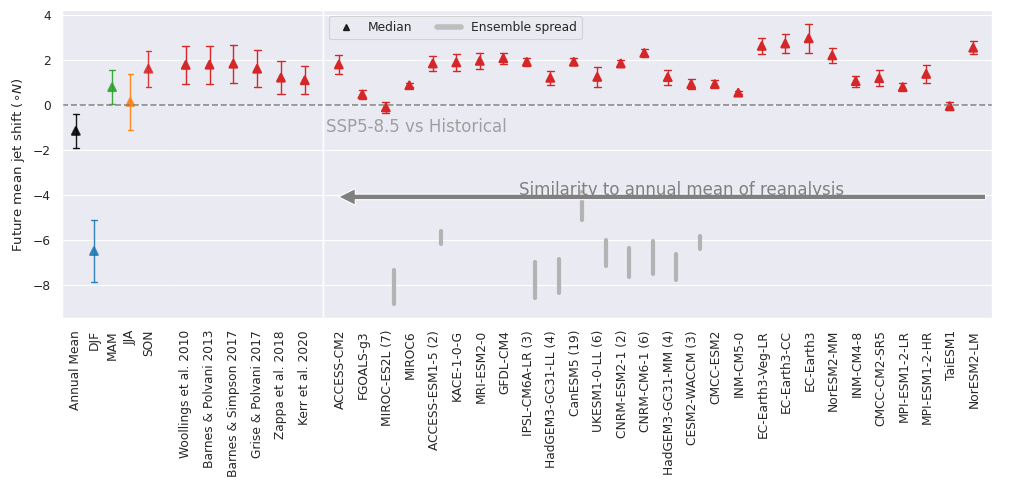

In [585]:
sns.set_context('paper')
sns.set_style('darkgrid')
cols_to_use = ['Woollings et al. 2010', 'Barnes & Polvani 2013', 'Barnes & Simpson 2017', 'Grise & Polvani 2017',\
               'Zappa et al. 2018','Kerr et al. 2020'] # 'Barnes & Polvani 2015'
errorbar_to_use = ('sd', 1)

fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey=True, width_ratios=[0.15, 0.2, 0.9])
plt.subplots_adjust(wspace=0)

sns.pointplot(df_future_hist_diff_season_by_model[["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON']].dropna(), capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, palette=['k', 'C0', 'C2', 'C1', 'C3'], ax=axes[0])
sns.pointplot(df_diff_son_ens_mean.loc[son_hist_and_future_mean_diffs_w_mean_ensemble_means.index], color='C3', capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[1])
sns.pointplot(df_diff_son_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean].T, color='C3', capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[2]);
offset = matplotlib.transforms.ScaledTranslation(-(1/72.), 0, axes[2].figure.dpi_scale_trans)
trans = axes[2].collections[0].get_transform()
axes[2].collections[0].set_transform(trans + offset)
for line in axes[2].lines:
    trans = line.get_transform()
    line.set_transform(trans + offset)
    
sns.pointplot(multi_r_models_w_all_models, capsize=.0, estimator='median', errorbar=errorbar_to_use,\
              markers='', errwidth=3, join=False, color='0.7',  ax=axes[2]);

offset = matplotlib.transforms.ScaledTranslation(5/72., 0, axes[2].figure.dpi_scale_trans)
trans = axes[2].collections[1].get_transform()
axes[2].collections[1].set_transform(trans + offset)
for line in axes[2].lines[len(axes[2].lines)//2:]:
    trans = line.get_transform()
    line.set_transform(trans + offset)

axes[0].set_xticklabels(["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON'], rotation=90);
axes[1].set_xticklabels(cols_to_use, rotation=90);
axes[2].set_xticklabels(sorted_models_with_group_count, rotation=90);
plt.setp(axes[0].collections, alpha=.8); #for the markers
plt.setp(axes[0].lines, alpha=.9);    #for the lines
axes[2].annotate('', xy=(-1.6, -4.1), xytext=(29, -4.1),
            arrowprops=dict(facecolor='grey', width=4, shrink=0.05), annotation_clip=False)
axes[2].text(s="Similarity to annual mean of reanalysis", x=7.6, y=-4., c='grey', fontsize=12)
black_triangle = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=5, alpha=.8, label='Median')
grey_line = mlines.Line2D([0], [0], color='0.7', linestyle='-', lw=4,
                        alpha=.8, label='Ensemble spread')
axes[2].legend(handles=[black_triangle, grey_line], ncols=2)
axes[0].hlines(-0, -0.75, 5.5, 'grey', '--', alpha=.9)
axes[1].hlines(-0, -1.5, 7.75, 'grey', '--', alpha=.9)
axes[2].hlines(-0, -1.75, 27.75, 'grey', '--', alpha=.9)
axes[0].set_xlim(-0.75, 5.4)
axes[1].set_xlim(-0.5, 5.75)
axes[2].set_xlim(-0.75, 27.75)
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].set_ylabel("Future mean jet shift (${\circ N}$)")
axes[2].text(s="SSP5-8.5 vs Historical", x=-0.6, y=-1.2, fontsize=12, color='grey', alpha=.7)
# fig.savefig('figures/figure_4_jja.png', bbox_inches='tight', dpi=300)

## alternative with ens spread on metric

/home/thomaskeel/miniconda3/envs/jsanalysis/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6)]) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/thomaskeel/miniconda3/envs/jsanalysis/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6),

Text(-0.7, -1.4, 'SSP5-8.5 vs Historical')

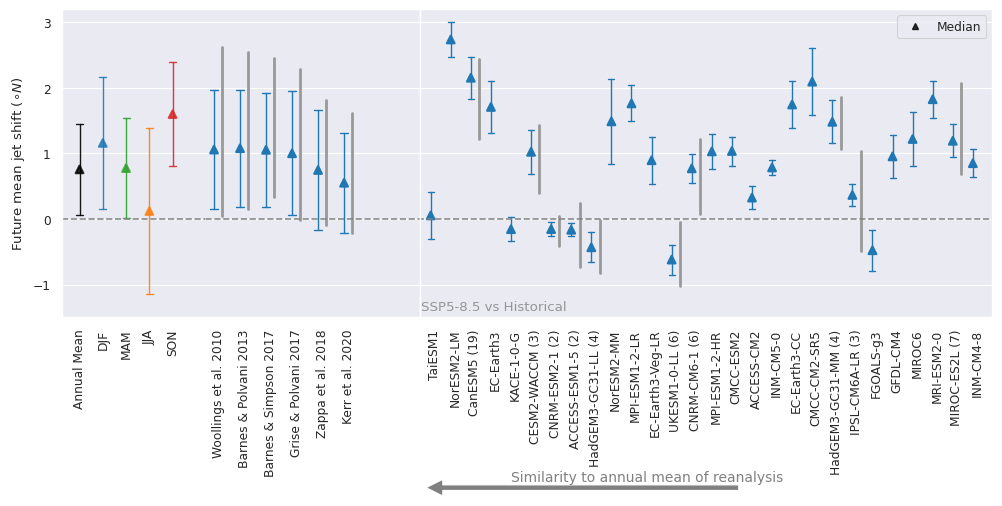

In [291]:
sns.set_context('paper')
sns.set_style('darkgrid')
cols_to_use = ['Woollings et al. 2010', 'Barnes & Polvani 2013', 'Barnes & Simpson 2017', 'Grise & Polvani 2017',\
               'Zappa et al. 2018','Kerr et al. 2020']
errorbar_to_use = ('sd', 1)

fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey=True, width_ratios=[0.2, 0.3, 0.8])
plt.subplots_adjust(wspace=0)

sns.pointplot(df_future_hist_diff_season_by_model[["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON']].dropna(), capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, palette=['k', 'C0', 'C2', 'C1', 'C3'], ax=axes[0])

## BY METRIC
sns.pointplot(df_diff_djf_ens_mean.loc[djf_hist_and_future_mean_diffs_w_mean_ensemble_means.index], capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[1])
offset = matplotlib.transforms.ScaledTranslation(-(3/72.), 0, axes[1].figure.dpi_scale_trans)
trans = axes[1].collections[0].get_transform()
axes[1].collections[0].set_transform(trans + offset)
for line in axes[1].lines:
    trans = line.get_transform()
    line.set_transform(trans + offset)
sns.pointplot(df_diff_djf.loc[models_in_groups_in_future], capsize=.0, estimator='median', errorbar=errorbar_to_use,\
              markers = '', errwidth=2, join=False, color=(0.6, 0.6, 0.6), ax=axes[1])
offset = matplotlib.transforms.ScaledTranslation(3/72., 0, axes[1].figure.dpi_scale_trans)
trans = axes[1].collections[1].get_transform()
axes[1].collections[1].set_transform(trans + offset)
for line in axes[1].lines[len(axes[1].lines)//2:]:
    trans = line.get_transform()
    line.set_transform(trans + offset)

## BY MODEL
sns.pointplot(df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean].T, capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[2]);
offset = matplotlib.transforms.ScaledTranslation(-(3/72.), 0, axes[2].figure.dpi_scale_trans)
trans = axes[2].collections[0].get_transform()
axes[2].collections[0].set_transform(trans + offset)
for line in axes[2].lines:
    trans = line.get_transform()
    line.set_transform(trans + offset)
    
sns.pointplot(multi_r_models_w_all_models, capsize=.0, estimator='median', errorbar=errorbar_to_use,\
              markers='', errwidth=2, join=False, color=(0.6, 0.6, 0.6),  ax=axes[2]);

offset = matplotlib.transforms.ScaledTranslation(3/72., 0, axes[2].figure.dpi_scale_trans)
trans = axes[2].collections[1].get_transform()
axes[2].collections[1].set_transform(trans + offset)
for line in axes[2].lines[len(axes[2].lines)//2:]:
    trans = line.get_transform()
    line.set_transform(trans + offset)

axes[0].set_xticklabels(["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON'], rotation=90);
axes[1].set_xticklabels(cols_to_use, rotation=90);
axes[2].set_xticklabels(sorted_models_with_group_count, rotation=90);
plt.setp(axes[0].collections, alpha=.8); #for the markers
plt.setp(axes[0].lines, alpha=.9);    #for the lines
axes[2].annotate('', xy=(-1.3, -4.1), xytext=(16, -4.1),
            arrowprops=dict(facecolor='grey', width=4, shrink=0.05), annotation_clip=False)
axes[2].text(s="Similarity to annual mean of reanalysis", x=3.8, y=-4., c='grey', fontsize=10)
black_triangle = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=5, alpha=.8, label='Median')
axes[2].legend(handles=[black_triangle], ncols=2)
axes[0].hlines(-0, -0.75, 5.5, 'grey', '--', alpha=.9)
axes[1].hlines(-0, -1.5, 7.75, 'grey', '--', alpha=.9)
axes[2].hlines(-0, -1.75, 27.75, 'grey', '--', alpha=.9)
axes[0].set_xlim(-0.75, 5.4)
axes[1].set_xlim(-0.5, 7.75)
axes[2].set_xlim(-0.75, 27.75)
axes[0].set_ylim(-1.5, 3.2)
axes[1].set_ylim(-1.5, 3.2)
axes[2].set_ylim(-1.5, 3.2)
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].set_ylabel("Future mean jet shift (${\circ N}$)")
axes[2].text(s="SSP5-8.5 vs Historical", x=-0.7, y=-1.4, color='grey', alpha=.8)

# fig.savefig('figures/figure_4_with_ens_spread.png', bbox_inches='tight', dpi=300)

## alternative with no ens mean

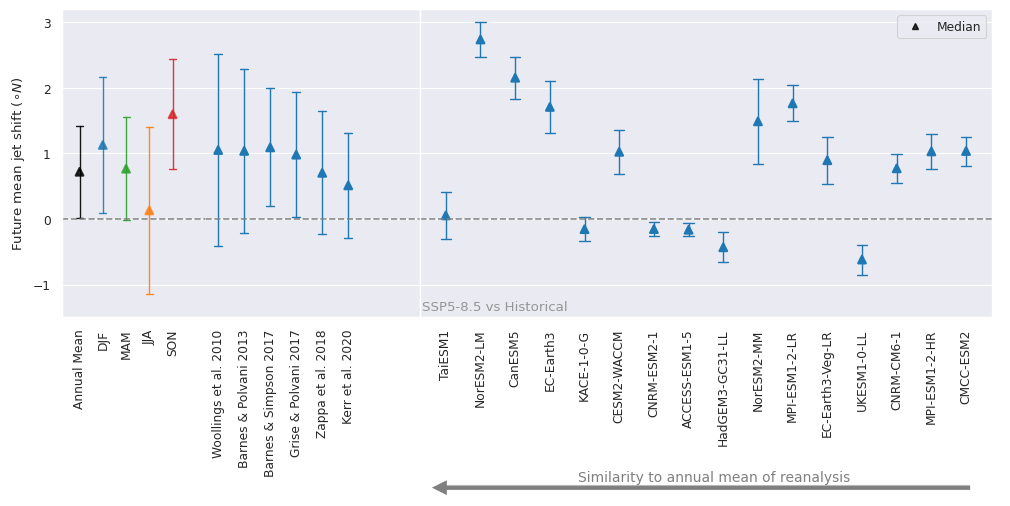

In [219]:
sns.set_context('paper')
sns.set_style('darkgrid')
cols_to_use = ['Woollings et al. 2010', 'Barnes & Polvani 2013', 'Barnes & Simpson 2017', 'Grise & Polvani 2017',\
               'Zappa et al. 2018','Kerr et al. 2020']
errorbar_to_use = ('sd', 1)

fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey=True, width_ratios=[0.2, 0.3, 0.8])
plt.subplots_adjust(wspace=0)

sns.pointplot(df_future_hist_diff_season_by_model[["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON']].dropna(), capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, palette=['k', 'C0', 'C2', 'C1', 'C3'], ax=axes[0])
sns.pointplot(df_diff_djf_ens_mean.loc[djf_hist_and_future_mean_diffs_w_mean_ensemble_means.index], capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[1])
sns.pointplot(df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean].T, capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[2]);

# sns.pointplot(multi_r_models, errorbar=errorbar_to_use,  capsize=.3, estimator='median',\
#               markers = '^', errwidth=1, join=False, ax=axes[2]);

axes[0].set_xticklabels(["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON'], rotation=90);
axes[1].set_xticklabels(cols_to_use, rotation=90);
axes[2].set_xticklabels(df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean].index, rotation=90);
plt.setp(axes[0].collections, alpha=.8); #for the markers
plt.setp(axes[0].lines, alpha=.9);    #for the lines
axes[2].annotate('', xy=(-1.3, -4.1), xytext=(16, -4.1),
            arrowprops=dict(facecolor='grey', width=4, shrink=0.05), annotation_clip=False)
axes[2].text(s="Similarity to annual mean of reanalysis", x=3.8, y=-4., c='grey', fontsize=10)
black_triangle = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=5, alpha=.8, label='Median')
axes[2].legend(handles=[black_triangle], ncols=2)
axes[0].hlines(-0, -0.75, 5.5, 'grey', '--', alpha=.9)
axes[1].hlines(-0, -1.5, 7.75, 'grey', '--', alpha=.9)
axes[2].hlines(-0, -1.75, 15.75, 'grey', '--', alpha=.9)
axes[0].set_xlim(-0.75, 5.4)
axes[1].set_xlim(-0.5, 7.75)
axes[2].set_xlim(-0.75, 15.75)
axes[0].set_ylim(-1.5, 3.2)
axes[1].set_ylim(-1.5, 3.2)
axes[2].set_ylim(-1.5, 3.2)
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].set_ylabel("Future mean jet shift (${\circ N}$)")
axes[2].text(s="SSP5-8.5 vs Historical", x=-0.7, y=-1.4, color='grey', alpha=.8)

# fig.savefig('figures/figure_4_only_ensmean.png', bbox_inches='tight', dpi=300)

### EXTRA: trend

In [220]:
sns.set_style('darkgrid')
cols_to_use = ['Woollings et al. 2010', 'Barnes & Polvani 2013', 'Barnes & Simpson 2017', 'Grise & Polvani 2017',\
               'Zappa et al. 2018','Kerr et al. 2020']
errorbar_to_use = ('ci', 95)

fig, axes = plt.subplots(1,2, figsize=(7, 4), sharey=True, width_ratios=[0.2, 0.4])
plt.subplots_adjust(wspace=0)
sns.pointplot(djf_hist_and_future_trend_diffs_w_mean_ensemble_means['Mean'], capsize=.15, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1.5, color='k', join=False, ax=axes[0])
sns.pointplot(djf_hist_and_future_trend_diffs_w_mean_ensemble_means[cols_to_use], capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[1])
axes[0].scatter("Mean", djf_hist_and_future_trend_diffs_w_mean_ensemble_means["Mean"].mean(), c='k')
axes[1].scatter(cols_to_use, djf_hist_and_future_trend_diffs_w_mean_ensemble_means[cols_to_use].mean())
axes[0].hlines(-0, -0.5, 1.5, 'grey', '-', alpha=.4)
axes[1].hlines(-0, -0.5, 6.5, 'grey', '-', alpha=.4)
# axes[0].set_xlim(-0.4, .4)
# axes[1].set_xlim(-0.5, 6.5)
axes[0].set_ylim(-0.1, .1)
axes[1].set_ylim(-0.1, .1)
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].set_xticklabels(["Mean"], rotation=90);
axes[1].set_xticklabels(cols_to_use, rotation=90);
# plt.suptitle('')

black_circle = mlines.Line2D([], [], color='k', marker='o', linestyle='None',
                          markersize=3, alpha=.8, label='Mean')
black_square = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=3, alpha=.8, label='Median')
axes[1].legend(handles=[black_circle, black_square], ncols=2)
axes[0].set_ylabel("Mean latitude (${\circ N}$)")
fig.suptitle("CMIP6 Historical vs CMIP6 SSP5-8.5")
# fig.savefig("figures/summary_figures/cross_metric_vs_by_metric_annual_mean_diff.png", dpi=200, bbox_inches='tight')

Text(0.5, 0.98, 'CMIP6 Historical vs CMIP6 SSP5-8.5')

Error in callback <function _draw_all_if_interactive at 0x7f1aacf36160> (for post_execute):


ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--],
             mask=[ True],
       fill_value=1e+20,
            dtype=float64)

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--],
             mask=[ True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 700x400 with 2 Axes>